# Automatic Instance Segmentation with Segment Anything for Microscopy

This notebook shows how to use Segment Anything (SAM) for automatic instance segmentation, using the corresponding functionality from `µsam` (Segment Anything for Microscopy). We use immunoflourescence microscopy images, abbreviated as `Covid IF` (from [Pape et al](https://doi.org/10.1002/bies.202000257)), in this notebook. The functionalities shown here should work for your (microscopy) images too!

We demonstrate using two different functionalities:

1. Automatic Mask Generation (AMG): The "Segment Anything" feature where positive point prompts are sampled in a grid over the entire image to perform instance segmentation.
2. Automatic Instance Segmentation (AIS): A new feature introduced in `µsam` where we train an additional decoder to perform automatic instance segmentation. This method is much faster in AMG and yields better results if it is applied to data that is similar to the finetuning dataset.

## Install `condacolab` for Package Management

The first step is to have a package manager to install `µsam` and other relevant packages.

NOTE: Please run the next two cells one after the other.

In [1]:
# Step 1: Install `condacolab` for installing conda and other related package managers.
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/download/24.11.2-1_colab/Miniforge3-colab-24.11.2-1_colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:09
🔁 Restarting kernel...


NOTE: When you run the previous code cell, the kernel has restarted automatically in Kaggle. Please proceed further without the need of any manual kernel restarts.

In [1]:
# Step 2: Validate if `condacolab` was installed correctly.
import condacolab
condacolab.check()

✨🍰✨ Everything looks OK!


If you see `✨🍰✨ Everything looks OK!` in the previous cell's output, you are good to proceed!

## Running this notebook

If you have an environment with `µsam` on your computer you can run this notebook in there. You can follow the [installation instructions](https://computational-cell-analytics.github.io/micro-sam/micro_sam.html#installation) to install it on your computer.

You can also run this notebook in the cloud on [Kaggle Notebooks](https://www.kaggle.com/code/). This service offers free usage of a GPU to speed up running the code. The next cells will take care of the installation for you if you are using it.

In [2]:
# Check if we are running this notebook on kaggle, google colab or local compute resources.
import os
current_spot = os.getcwd()

if current_spot.startswith("/kaggle/working"):
    print("Kaggle says hi!")
    root_dir = "/kaggle/working"

elif current_spot.startswith("/content"):
    print("Google Colab says hi!")
    print(" NOTE: The scripts have not been tested on Google Colab, you might need to adapt the installations a bit.")
    root_dir = "/content"

else:
    msg = "You are using a behind-the-scenes resource. Follow our installation instructions here:"
    msg += " https://computational-cell-analytics.github.io/micro-sam/micro_sam.html#installation"
    print(msg)
    root_dir = ""  # overwrite to set the root directory, where the data, checkpoints, and all relevant stuff will be stored

Kaggle says hi!


### Installation

The next cells will install the `micro_sam` library on Kaggle Notebooks. **Please skip these cells and go to `Importing the libraries` if you are running the notebook on your own computer.**

In [3]:
# Install `micro-sam` from `conda-forge`.
!mamba install -y -q -c conda-forge micro_sam > /dev/null 2>&1
!pip uninstall -y --quiet napari  # GUI backends are not supported in Kaggle / Google Colab, let's remove it to avoid errors.

## Importing the libraries

Known Issues on **Kaggle Notebooks**:

1. ```bash
    2024-05-08 14:56:42.941557: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
    2024-05-08 14:56:42.941680: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
    2024-05-08 14:56:43.062385: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
    ```

    - We have received this warning while testing this notebook on Kaggle. We suspect that the complains originate from the tensorflow suite. It does not lead to any issues while making use of the installed packages. You can proceed and ignore the warnings.

In [4]:
import os
from glob import glob
from typing import Optional, Union, Tuple

import h5py
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import label as connected_components

import torch

from torch_em.util.util import get_random_colors
from torch_em.data.datasets.light_microscopy.covid_if import get_covid_if_data

from micro_sam.evaluation.model_comparison import _enhance_image
from micro_sam.automatic_segmentation import get_predictor_and_segmenter, automatic_instance_segmentation

2025-04-16 11:04:33.946382: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744801474.161874     167 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744801474.222531     167 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Let's download the dataset

Download the example data from Zenodo.

In [5]:
data_dir = os.path.join(root_dir, "data", "covid_if")
get_covid_if_data(path=data_dir, download=True)
print(f"Your data is stored at: {data_dir}")

Download https://zenodo.org/record/5092850/files/covid-if-groundtruth.zip?download=1 to /kaggle/working/data/covid_if/covid-if.zip: 100%|██████████| 491M/491M [00:24<00:00, 21.3MB/s] 


Download successful and checksums agree.
Your data is stored at: /kaggle/working/data/covid_if


## Let's visualize how our samples look

We check out the example data visually with matplotlib and visualize the images and the ground-truth segmentations.

In [6]:
# Convenience function to plot images side-by-side
def plot_samples(image, gt, segmentation=None):
    n_images = 2 if segmentation is None else 3
    fig, ax = plt.subplots(1, n_images, figsize=(10, 10))

    ax[0].imshow(_enhance_image(image, do_norm=True), cmap="gray")
    ax[0].axis("off")
    ax[0].set_title("Image")

    gt = connected_components(gt)
    ax[1].imshow(gt, cmap=get_random_colors(gt), interpolation="nearest")
    ax[1].axis("off")
    ax[1].set_title("Ground Truth")

    if n_images == 3:
        ax[2].imshow(segmentation, cmap=get_random_colors(segmentation), interpolation="nearest")
        ax[2].axis("off")
        ax[2].set_title("Prediction")

    plt.show()
    plt.close()

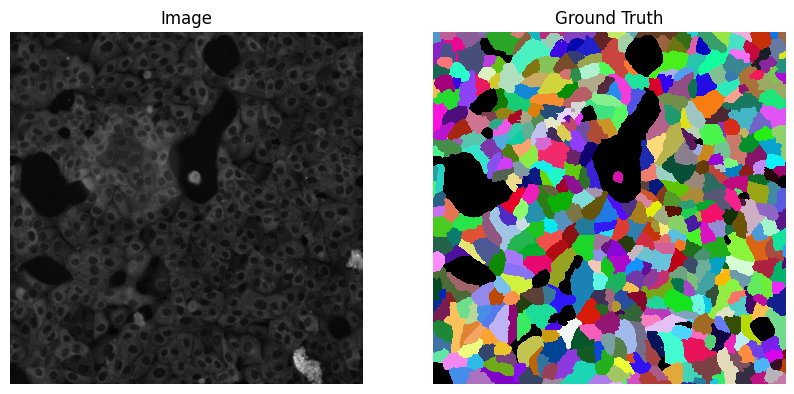

In [7]:
sample_paths = sorted(glob(os.path.join(data_dir, "*")))

for sample_path in sample_paths:
    with h5py.File(sample_path, "r") as f:
        raw = f["raw/serum_IgG/s0"][:]
        labels = f["labels/cells/s0"][:]

    plot_samples(image=raw, gt=labels)

    break  # comment this out in case you want to visualize all images.

### Next, we create convenience functions for automatic segmentation methods

In [8]:
def run_automatic_instance_segmentation(
    image: np.ndarray,
    checkpoint_path: Optional[Union[os.PathLike, str]] = None,
    model_type: str = "vit_b_lm",
    device: Optional[Union[str, torch.device]] = None,
    tile_shape: Optional[Tuple[int, int]] = None,
    halo: Optional[Tuple[int, int]] = None,
):
    """Automatic Instance Segmentation (AIS) by training an additional instance decoder in SAM.

    NOTE: AIS is supported only for `µsam` models.

    Args:
        image: The input image.
        checkpoint_path: The path to stored checkpoints.
        model_type: The choice of the `µsam` model.
        device: The device to run the model inference.
        tile_shape: The tile shape for tiling-based segmentation.
        halo: The overlap shape on each side per tile for stitching the segmented tiles.

    Returns:
        The instance segmentation.
    """
    # Step 1: Get the 'predictor' and 'segmenter' to perform automatic instance segmentation.
    predictor, segmenter = get_predictor_and_segmenter(
        model_type=model_type,  # choice of the Segment Anything model
        checkpoint=checkpoint_path,  # overwrite to pass your own finetuned model.
        device=device,  # the device to run the model inference.
        amg=False,  # set the automatic segmentation mode to AIS.
        is_tiled=(tile_shape is not None),  # whether to run automatic segmentation with tiling.
    )

    # Step 2: Get the instance segmentation for the given image.
    prediction = automatic_instance_segmentation(
        predictor=predictor,  # the predictor for the Segment Anything model.
        segmenter=segmenter,  # the segmenter class responsible for generating predictions.
        input_path=image,  # the filepath to image or the input array for automatic segmentation.
        ndim=2,  # the number of input dimensions.
        tile_shape=tile_shape,  # the tile shape for tiling-based prediction.
        halo=halo,  # the overlap shape for tiling-based prediction.
    )

    return prediction


def run_automatic_mask_generation(
    image: np.ndarray,
    checkpoint_path: Optional[Union[os.PathLike, str]] = None,
    model_type: str = "vit_b_lm",
    device: Optional[Union[str, torch.device]] = None,
    tile_shape: Optional[Tuple[int, int]] = None,
    halo: Optional[Tuple[int, int]] = None,
):
    """Automatic Mask Generation (AMG) is the automatic segmentation method offered by SAM.

    NOTE: AMG is supported for both Segment Anything models and `µsam` models.

    Args:
        image: The input image.
        checkpoint_path: The path to stored checkpoints.
        model_type: The choice of the SAM / `µsam` model.
        device: The device to run the model inference.
        tile_shape: The tile shape for tiling-based segmentation.
        halo: The overlap shape on each side per tile for stitching the segmented tiles.

    Returns:
        The instance segmentation.
    """
    # Step 1: Get the 'predictor' and 'segmenter' to perform automatic instance segmentation.
    predictor, segmenter = get_predictor_and_segmenter(
        model_type=model_type,  # choice of the Segment Anything model
        checkpoint=checkpoint_path,  # overwrite to pass your own finetuned model.
        device=device,  # the device to run the model inference.
        amg=True,  # set the automatic segmentation mode to AMG.
        is_tiled=(tile_shape is not None),  # whether to run automatic segmentation with tiling.
    )

    # Step 2: Get the instance segmentation for the given image.
    prediction = automatic_instance_segmentation(
        predictor=predictor,  # the predictor for the Segment Anything model.
        segmenter=segmenter,  # the segmenter class responsible for generating predictions.
        input_path=image,  # the filepath to image or the input array for automatic segmentation.
        ndim=2,  # the number of input dimensions.
        tile_shape=tile_shape,  # the tile shape for tiling-based prediction.
        halo=halo,  # the overlap shape for tiling-based prediction.
    )

    return prediction

### Let's run the *Segment Anything for Microscopy* models

`µsam` introduces an additional decoder to improve the segmentation quality by learning the objects with a better heuristic.

We test the smallest light microscopy (LM) `µsam` model on the microscopy data, ViT Base (LM) (abbreviated as `vit_b_lm`).

100%|████████████████████████████████████████| 375M/375M [00:00<00:00, 420GB/s]
100%|█████████████████████████████████████| 44.1M/44.1M [00:00<00:00, 53.3GB/s]
Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:00<00:00,  7.85it/s]


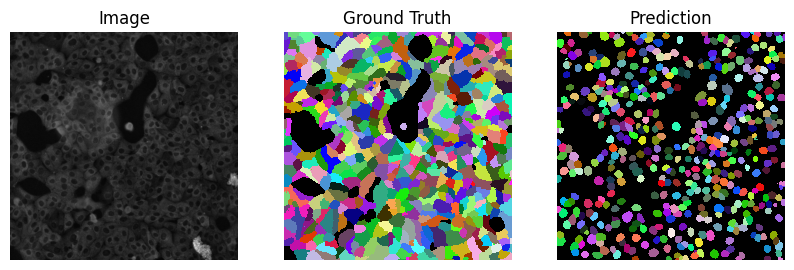

In [9]:
model_choice = "vit_b_lm"

for sample_path in sample_paths:
    with h5py.File(sample_path, "r") as f:
        raw = f["raw/serum_IgG/s0"][:]
        labels = f["labels/cells/s0"][:]

    # NOTE: If you have large images, we recommend using tiling for automatic segmentation.
    # eg. for a training patch size of (512, 512), you can provide the following example combination:
    # 'tile_shape=(384, 384). halo=(64, 64)' for running automatic segmentation over tiles.
    prediction = run_automatic_instance_segmentation(raw, model_type=model_choice)

    plot_samples(image=raw, gt=labels, segmentation=prediction)

    break  # comment this out in case you want to visualize all images

The segmentation quality looks okay. How does it compare with the original automatic segmentation mode (called AMG, automatic mask generation) offered by the original SAM?

### Let's run the default *Segment Anything* models

We test the smallest default SAM model on the microscopy data, ViT Base (abbreviated as `vit_b`).

100%|████████████████████████████████████████| 375M/375M [00:00<00:00, 452GB/s]
Predict masks for point grid prompts: 100%|██████████| 16/16 [00:22<00:00,  1.41s/it]


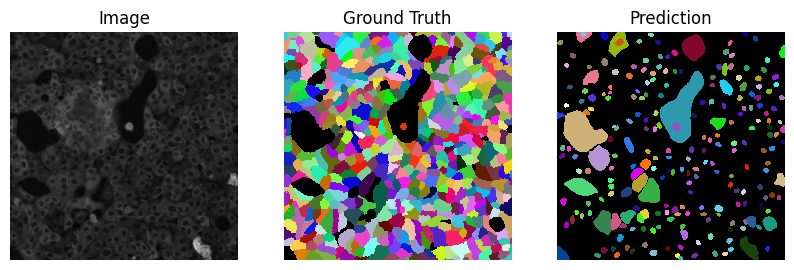

In [10]:
# For consistency, we choose the same configuration of the original model.

model_choice = "vit_b"

for sample_path in sample_paths:
    with h5py.File(sample_path, "r") as f:
        raw = f["raw/serum_IgG/s0"][:]
        labels = f["labels/cells/s0"][:]

    # NOTE: If you have large images, we recommend using tiling for automatic segmentation.
    # eg. for a training patch size of (512, 512), you can provide the following example combination:
    # 'tile_shape=(384, 384). halo=(64, 64)' for running automatic segmentation over tiles.
    prediction = run_automatic_mask_generation(raw, model_type=model_choice)

    plot_samples(image=raw, gt=labels, segmentation=prediction)

    break  # comment this out in case you want to visualize all images

As we see above, the automatic segmentation method offered by Segment Anything does not generalize well (at all) for segmenting cells in the above image.

To address this problem, "Segment Anything for Microscopy" introduced the new automatic instance segmentation (AIS) feature (see above), which is the recommended workflow.

## What next?

Question: Are you happy with the segmentations?
1. If your answer is "YES", looks like you are good to go with your segmentations. Feel free to test it on your custom data.
2. If you think there are missed out objects / incorrect segmentations, and there's room for improvement:
    1. We recommend you to use our napari-based [annotation tool](https://computational-cell-analytics.github.io/micro-sam/micro_sam.html#annotation-tools) to improve your segmentations.
    2. If you want to improve the automatic segmentation quality, we recommend you to finetune the default SAM models OR the `µsam` models, based on your initial assessment of the segmentation quality of both models.
3. If you think the models perform poorly, we recommend you to finetune the default SAM models on your custom dataset. There are two situations here:
    1. In case you do not have any ground-truth labels, we recommend generating the desired labels using our [annotator tool](https://computational-cell-analytics.github.io/micro-sam/micro_sam.html#annotation-tools)
    2. In case you do have ground-truth labels, we suggest going ahead with finetuning already (you can choose to use the [python scripts](https://github.com/computational-cell-analytics/micro-sam/blob/master/examples/finetuning/finetune_hela.py) or the [tool](https://computational-cell-analytics.github.io/micro-sam/micro_sam.html#finetuning-ui) for this.)

[Here](https://github.com/computational-cell-analytics/micro-sam/blob/master/notebooks/sam_finetuning.ipynb) is the link to the notebook on how to get quickly started with finetuning on your custom dataset.

*This notebook was last ran on April 16, 2025*